<a href="https://colab.research.google.com/github/kento-koyama/bayesian_predictive_micro_ICPMF12/blob/main/Workshop_(inactivation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fitting of Bayesian model
##Installation and Loading libraries.  
>**pystan**: Bayesian MCMC  
>**nest_asyncio**: Library for stan in notebook.  
>**pandas**: Data manipulation  
> **numpy**: Data calculation  
>**seaborn**: Visualization  
>**matplotlib.pyplot**: Visualization  
>**arviz**: Visualization of pystan  
   
- The softwares will be installed in the temporary cloud computer.  
- **Nothing will be installed in your own PC**. 
- It must be installed at the very beginning of every calculation.   
- The installation could take a little time.

In [ ]:
# Installation
!pip install pystan
!pip install nest_asyncio
# Importing
import nest_asyncio
nest_asyncio.apply()
import stan 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import math
import arviz as az
from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 KB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Data reading and preperation

The data imported from reported article through github: [Hiura, S., Abe, H., Koyama, K. & Koseki, S. Bayesian generalized linear model for simulating bacterial inactivation/growth considering variability and uncertainty. Front. Microbiol. 12, 674364 (2021)](https://doi.org/10.3389/fmicb.2021.674364).

In [ ]:
# Data importing
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/inactivation/data/bayesian_fitting.csv"
data = pd.read_csv(url, encoding='utf-8')

# Data hundling
TIME = data['TIME'] # Heating time
Nt = data['Nt'] # CFU/mL (not Log)
Initial = data['Initial'] # ID of initail count of each heating test

In [ ]:
data

,TIME,Nt,Initial
0,0.000,84500,1
1,0.000,89000,2
2,0.000,78000,3
3,0.667,36200,0
4,0.667,37000,0
5,0.667,34750,0
6,1.333,14020,0
7,1.333,11935,0
8,1.333,17760,0
9,2.000,3332,0


##Model construction
- The `stan_code` include a the *script* for stan (C language).  
- The stan script is constructed by several sections.

###Data section
Definition of the input data shape  

    data {
      int M; # Data count
      int<lower=0> Nt[M]; # Survival count CFU
      real TIME[M]; # Heating time
      int Initial[M]; # ID of initail count data
    } 
###Parameters section
Setting of the parameters  

    parameters {
	  real<lower=0> delta; # delta parameter of the Weibull model
	  real<lower=0> power; # power parameter of the Weibull model  
	  real<lower=0> n0; #Estimation of the initial number
    }
###Transformed parameters section
Changing expression and define the prediction   
Equation from the Weibull model:

$N_{(t)pred} = N_{(0)}\times 10^{-{{\displaystyle(\frac{t}{\delta})}^p}}$ 


    transformed parameters {
      real<lower=0> Nt_pred[M]; # Mean prediction from the Weibull model 
      for (m in 1:M) {        # Roop function for data count
        Nt_pred[m] = n0*(10^(-((TIME[m]/delta)^power))); # Weibull model estimation
      }
    }
###Model section
Definition of prior distributions  

    model {
      for (m in 1:M) {
        if (Initial[m] != 0 ) {
          Nt[Initial[m]] ~ poisson(n0); #The observed initial count follows the Poisson model (assumption)      
        }
        Nt[m] ~ poisson(Nt_pred[m]); #The observed survival count follows the Poisson model (assumption)
      }
    }

In [ ]:
stan_code = """
  data {
    int M; // Data count
	  array[M] int<lower=0> Nt; // Survival count CFU
	  array[M] real TIME; // Heating time
	  array[M] int Initial; // ID of initail count data
  }

  parameters {
	  real<lower=0> delta; // delta parameter of the Weibull model
	  real<lower=0> power; // power parameter of the Weibull model  
	  real<lower=0> n0; //Estimation of the initial number
  }

	transformed parameters {
	  array[M] real<lower=0> Nt_pred; // Mean prediction from the Weibull model 
		
		for (m in 1:M) {        // Roop function for data count
        Nt_pred[m] = n0*(10^(-((TIME[m]/delta)^power))); // Weibull model estimation
    }
  }

  model {
	  for (m in 1:M) {
		  if (Initial[m] != 0 ) {
			  Nt[Initial[m]] ~ poisson(n0); // The observed initial count follows the Poisson model (assumption)
		  }      
      Nt[m] ~ poisson(Nt_pred[m]); // The observed survival count follows the Poisson model (assumption)
    }
  }

"""



###Setting of dataset for stan


In [ ]:
stan_data = data.to_dict('list') # transforming to list type (stan receives list type dictionary)
stan_data.update({'M':len(data)}) # Adding the data count data 

##Building the MCMC calculation frame including the dataset. 
- It could take a little time.

In [ ]:
posterior = stan.build(stan_code, data=stan_data)

Building...



Building: 54.1s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


##Bayesian inference using MCMC through Stan

In [ ]:
#MCMC sampling
fit_nuts = posterior.sample(num_samples=2500, num_chains=4, num_warmup = 5000)

Sampling:   0%
Sampling:  25% (7500/30000)
Sampling:  50% (15000/30000)
Sampling:  53% (15900/30000)
Sampling:  57% (17200/30000)
Sampling:  79% (23800/30000)
Sampling: 100% (30000/30000)
Sampling: 100% (30000/30000), done.
Messages received during sampling:
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Gradient evaluation took 6.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transi

###Summary of the Bayesian MCMC inference.    
You can check the parameters and the transformed parameters of
- mean: Mean
- sd: Standad deviation
- hdi_3%: 3% point
- hdi_97%: 97% point
- mcse_mean: Monte Carlo standard error for the mean
- mcse_sd: Monte Carlo standard error for the standard deviation
- ess_bulk: Bulk effective sample size
- ess_tail: the tail effective sample size
- r_hat: Rhat convergence diagnostic
  - We can check the convergence of the posteriors with an Rhat value of 1.0 or less than 1.1.

In [ ]:
az.summary(fit_nuts)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,1.590,0.002,1.586,1.594,0.000,0.000,7135.0,6898.0,1.0
power,1.206,0.003,1.200,1.212,0.000,0.000,5918.0,6497.0,1.0
n0,83647.156,116.453,83428.618,83859.009,1.412,0.998,6805.0,7426.0,1.0
Nt_pred[0],83647.156,116.453,83428.618,83859.009,1.412,0.998,6805.0,7426.0,1.0
Nt_pred[1],83647.156,116.453,83428.618,83859.009,1.412,0.998,6805.0,7426.0,1.0
Nt_pred[2],83647.156,116.453,83428.618,83859.009,1.412,0.998,6805.0,7426.0,1.0
Nt_pred[3],37301.053,94.531,37129.642,37481.459,1.068,0.755,7832.0,7703.0,1.0
Nt_pred[4],37301.053,94.531,37129.642,37481.459,1.068,0.755,7832.0,7703.0,1.0
Nt_pred[5],37301.053,94.531,37129.642,37481.459,1.068,0.755,7832.0,7703.0,1.0
Nt_pred[6],12996.323,40.274,12918.301,13070.030,0.425,0.300,8975.0,8267.0,1.0


###Traceplot of the estimated parameters
- It includes the transformed parameters
- We can visually check the convergence of the posteriors and unusual convergences through graphical analysis.

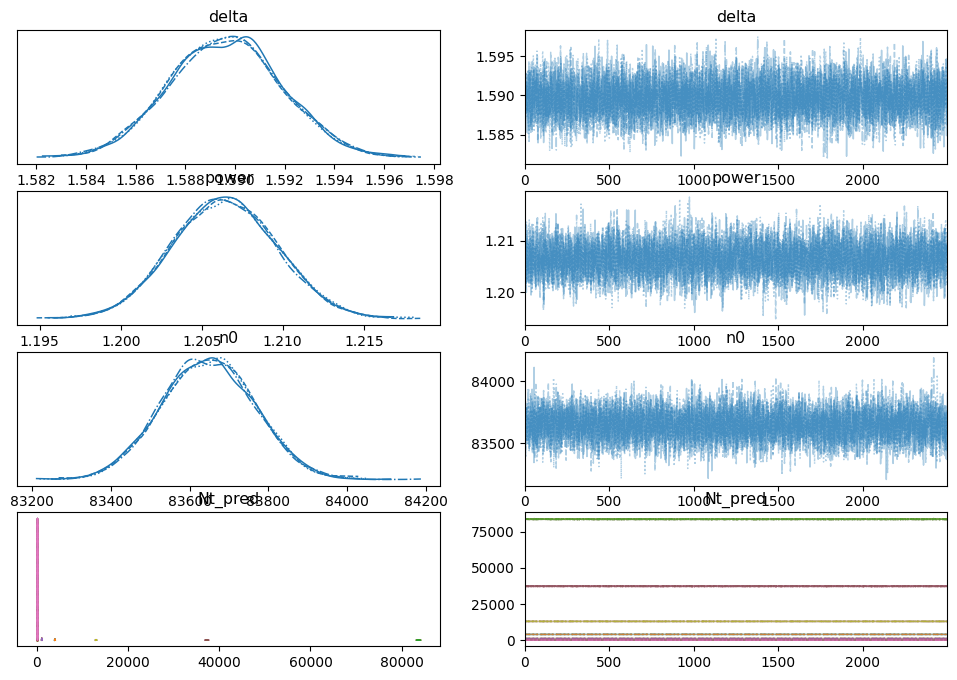

In [ ]:
az.plot_trace(fit_nuts)
plt.show()

###Extraction of the posteriors

In [ ]:
delta = fit_nuts['delta'][0,:] #delta parameter(δ)
power = fit_nuts['power'][0,:] #power parameter(p)

##Parameter matrix of the 
Definition of the parameters correlation function (Spearman)

In [ ]:
#correlation
def corrfunc(x, y, **kws):
    r, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.axis('on')
    txtcolor = 'black' if math.fabs(r) < 0.5 else 'white'
    ax.text(.5, .5, 'Corr:\n{:.2f}'.format(r),color=txtcolor, fontsize=28, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

Visualisation of parameter matrix and correlations and parameter distribution

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:181: UserWarning: The label '_nolegend_' of <matplotlib.patches.Patch object at 0x7f60ec203790> starts with '_'. It is thus excluded from the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


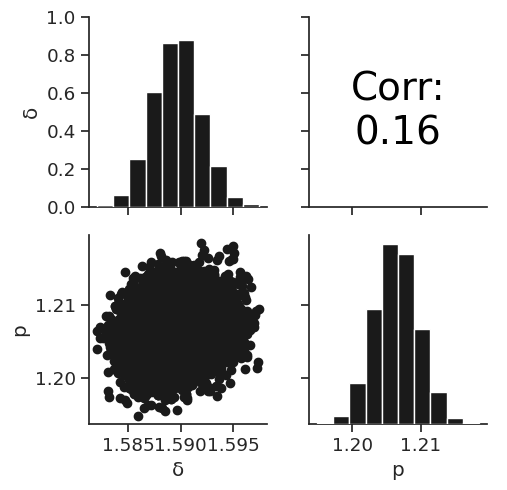

In [ ]:
#pairplot
sns.set(style='ticks', font_scale=1.2)
d = pd.DataFrame({'δ':delta,'p':power}, columns=['δ', 'p'])
g = sns.PairGrid(d)
g = g.map_diag(plt.hist,color='k')
g = g.map_lower(plt.scatter,color='k')
g = g.map_upper(corrfunc)
g = g.add_legend()
plt.show()

#Comparison of the kinetic & Bayesian Weibull model   
##Estimation of the kinetic model. 
Data import

In [ ]:
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/inactivation/data/frequentism_fitting.csv"
data = pd.read_csv(url, encoding='utf-8')

t = data['TIME']
R = data['Ratio']



Kinetically fitting of the Weibull model
- The parameters would be determined as one value.

In [ ]:
#fitting
parameter_initial = np.array([1.4,1.4])
def func(t, d, p):
    return -((t/d)**p)
parameter_optimal, covariance= scipy.optimize.curve_fit(func, t, R, p0=parameter_initial)
y = func(t, parameter_optimal[0], parameter_optimal[1])
print("delta parameter (δ) =", format(parameter_optimal[0]))
print("power parameter (p) =", format(parameter_optimal[1]))
RMSE = np.sqrt(mean_squared_error(R,y))
print("RMSE= ", format(RMSE))

delta parameter (δ) = 1.5848891703833252
power parameter (p) = 1.2615817915254068
RMSE=  0.17570346625247327


Kinetically prediction of the Weibull model.

In [ ]:
# of fitting
T = np.arange(0,6,0.05)
y = 4.9-((T/parameter_optimal[0])**parameter_optimal[1])

Extraction of posteriors

In [ ]:
delta = fit_nuts['delta'] #delta parameter(δ)
power = fit_nuts['power'] #power parameter(p)
N0 = 79000 #initial cell number

###Estimation from the estimated Bayesian model
**Credible interval**: The variated interval of the estimated curve lines  
**Predicted interval**: The variated interval of the estimated survival counts.  

In [ ]:
#Array setting for time
T0 =[]
for n in range(61):
    t0 = n*0.1
    T0.append(t0)
T1 = pd.DataFrame(T0)

#credible interval
y_cred_int = np.zeros((len(delta[0,:]),len(T0)))
for i in range(len(delta[0,:])):
    for j in range(len(T0)):
        y_cred_int[i,j] = N0*(10**(-((np.array(T0[j])/delta[0,i])**(power[0,i]))))
y_cred_int_975 = np.percentile(y_cred_int, 2.5, axis=0)
y_cred_int_025 = np.percentile(y_cred_int, 97.5, axis=0)
y_cred_int_500 = np.percentile(y_cred_int, 50.0, axis=0)
y_cred = np.log10(y_cred_int)
y_cred_975 = np.percentile(y_cred, 2.5, axis=0)
y_cred_025 = np.percentile(y_cred, 97.5, axis=0)
y_cred_500 = np.percentile(y_cred, 50.0, axis=0)

#predicted interval
y_pred_int = np.zeros((len(delta[0,:]),len(T0)))
for i in range(len(power[0,:])): 
    for j in range(len(T0)):    

        y_pred_int[i,j] = np.random.poisson(N0*10**(-((np.array(T0[j])/delta[0,i])**(power[0,i]))))
y_pred_int_975 = np.percentile(y_pred_int, 2.5, axis=0)
y_pred_int_025 = np.percentile(y_pred_int, 97.5, axis=0)
y_pred_int_500 = np.percentile(y_pred_int, 50.0, axis=0)
y_pred = np.log10(y_pred_int)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)


<ipython-input-17-061f2d43dcb5>:30: RuntimeWarning: divide by zero encountered in log10
  y_pred = np.log10(y_pred_int)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


###Visualisation of Kinetic prediction & Bayesian prediction of the Weibull model

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

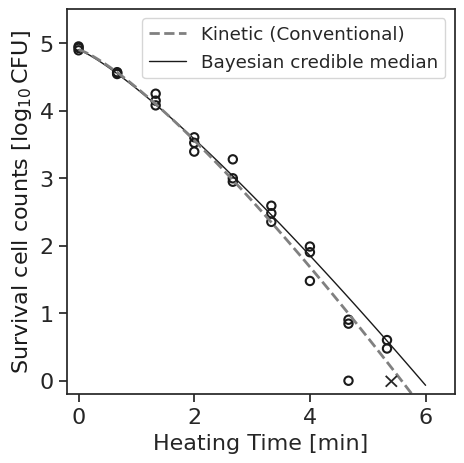

In [ ]:
#graph
#plot+frequentism+bayes
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/inactivation/data/bayesian_fitting.csv"
data2 = pd.read_csv(url, encoding='utf-8')
x = data2['TIME']
y1 = data2['Nt']
y1 = np.log10(y1)
fig = plt.figure()
plt.figure(figsize=(5,5))
sns.set_style(style='ticks')
plt.xlabel("Heating Time [min]", size=16)
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')    
plt.xticks([0,2,4,6])
plt.xlim(-0.2,6.5)
plt.ylim(-0.2,5.5)
plt.plot(T, y, color="gray", linestyle='dashed', lw=1.5, zorder=2, label='Kinetic (Conventional)')     
plt.text(5.25, -0.1, '×', fontsize=16)
plt.plot(T0,y_cred_500, linestyle = 'solid', zorder=1, color='k', lw=1.0, label='Bayesian credible median')
plt.scatter(x, y1, facecolors='None', edgecolors='k',linewidths=1.5) 
plt.legend()
plt.show()

#Stochastic expression from the estimated Bayesian model

In [ ]:
# data import
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/inactivation/data/850cell.csv"
data = pd.read_csv(url, encoding='utf-8')
time = data['TIME']
N = data['N']

In [ ]:
#Array setting for time
T =[]
for n in range(121):
    t0 = n*0.05
    T.append(t0)

##Estimation from the estimated Bayesian model
**Credible interval**: The variated interval of the estimated curve lines  
**Predicted interval**: The variated interval of the estimated survival counts.

In [ ]:
N0 = 850 #initial cell number


#credible interval
y_cred_int = np.zeros((len(delta[0,:]),len(T)))
for i in range(len(delta[0,:])):
    for j in range(len(T)):
        y_cred_int[i,j] = N0*(10**(-((np.array(T[j])/delta[0,i])**(power[0,i]))))

y_cred_int_975 = np.percentile(y_cred_int, 2.5, axis=0)
y_cred_int_025 = np.percentile(y_cred_int, 97.5, axis=0)
y_cred_int_500 = np.percentile(y_cred_int, 50.0, axis=0)
y_cred = np.log10(y_cred_int)
y_cred_975 = np.percentile(y_cred, 2.5, axis=0)
y_cred_025 = np.percentile(y_cred, 97.5, axis=0)
y_cred_500 = np.percentile(y_cred, 50.0, axis=0)

#predicted
y_pred_int = np.zeros((len(delta[0,:]),len(T)))
for i in range(len(delta[0,:])): 
    for j in range(len(T)):    
        y_pred_int[i,j] = np.random.poisson(N0*(10**(-((np.array(T[j])/delta[0,i])**(power[0,i])))))
y_pred_int_975 = np.percentile(y_pred_int, 2.5, axis=0)
y_pred_int_025 = np.percentile(y_pred_int, 97.5, axis=0)
y_pred_int_500 = np.percentile(y_pred_int, 50.0, axis=0)
y_pred = np.log10(y_pred_int)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)

<ipython-input-21-443be44bc0de>:26: RuntimeWarning: divide by zero encountered in log10
  y_pred = np.log10(y_pred_int)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [ ]:
#accuracy
Time = [3.0,3.3,3.6,4.0,4.3,4.6]
k=[0,1,2,3,4,5]
evaluation =[]
for t,k in zip(Time,k):
    T1 = int(t*20)
    y_pred_min = y_pred_int_975[T1]
    y_pred_max = y_pred_int_025[T1]
    hani =[]
    for l in range(60):
        number = 60*k + l
        N_target = N[number]
        if y_pred_min <= N_target <= y_pred_max :  
            ans= 1
        else:
            ans=0
        hani.append(ans)
    correct =hani.count(1)
    evaluation.append(correct)
accuracy = (sum(evaluation)/(len(Time)*60))*100
print('Interval including ratio: '+str(accuracy))

Interval including ratio: 96.38888888888889


/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

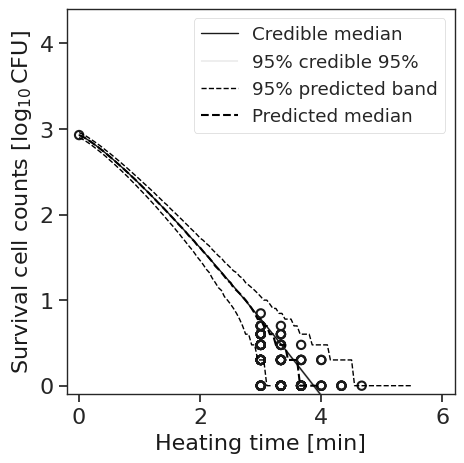

In [ ]:

#graph
fig = plt.figure()
plt.style.use('ggplot')
sns.set_style(style='ticks')
plt.figure(figsize=(5,5))
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.xlabel('Heating time [min]', fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')
plt.xlim(-0.2,6.2)
plt.ylim(-0.1,4.4)
plt.xticks([0,2,4,6])
plt.scatter(0,np.log10(N0),zorder=2,facecolors='none', edgecolors='k',lw=1.5)
plt.scatter(time,np.log10(N), zorder=2, facecolors ='none',edgecolors='k',linewidth=1.5)

#credible interval
plt.plot(T,y_cred_500, linestyle = 'solid', zorder=1, color='k', lw=1.0, label='Credible median')
plt.plot(T,y_cred_975, linestyle = 'solid', zorder=1, color='k', lw=0.1, label='95% credible')
plt.plot(T,y_cred_025, linestyle = 'solid', zorder=1, color='k', lw=0.1)

#prediction interval
plt.plot(T,y_pred_500, linestyle = 'dashed', zorder=2, color='black', lw=1.5, label='Predicted median')
plt.plot(T,y_pred_025, linestyle = 'dashed', zorder=2, color='black', lw=1.0, label='95% predicted')
plt.plot(T,y_pred_975, linestyle = 'dashed', zorder=2, color='black', lw=1.0)

plt.legend()
plt.show()